In [3]:
# 清空内核状态
%reset -f

In [4]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(123456)

In [5]:
#要设置的参数
Ex=0#E也要放小e6倍，这里是0就不放了
Ey=0
Ez=0#托卡马克里面没电场
B0=5#磁轴中心的磁感应强度为5T
q=2.5#安全因子，注意，不是电荷
R0=6.2#托卡马克大半径6.2m
q_over_m = 4.822452834e1  # 电荷与质量之比

#单位问题：跑太大的数，程序吃不消，得归一化。几个大数，q_over_m = 4.8e7，vx0vy0 1e6 5e6，interval 4.1473e-9，要动
#程序中，要让轨迹相对形状不变，又因为B和位置有关，所以轨迹数值也不能变
#a=q/m（E+vB），x=vt+0.5at^2
#让位移x=vt+0.5at^2不变，让interval扩大e6倍，让v缩小e6倍(让v0和x0在同一量级，这样好训练)，让q_over_m缩小e6倍，E也要放小e6倍，这样a放小e12个
def Bx(x,y,z):
    return B0/q*(-q*R0*y+z*x)/(x**2+y**2)
def By(x,y,z):
    return B0/q*(q*R0*x+z*y)/(x**2+y**2)
def Bz(x,y,z):
    return B0/q*(-1+R0/(x**2+y**2)**0.5)
    

target_x0=torch.tensor([7.2])
target_y0=torch.tensor([0.0])
target_z0=torch.tensor([0.0])
target_vx0=torch.tensor([1.0])
target_vy0=torch.tensor([5.0])#这里是通行α粒子数据
target_vz0=torch.tensor([0.0])


interval=4.147267104135095e-4#根据学长给的数据取值,e-3是小圈的1/2π,e-4就是小圈的60分之一，更精确
#总运动时间是n*interval
learning_rate=8e-4

stop_condition = 5e-4#停止训练的loss值要求


#设置初始权重
lamda1=2#lpde权重
lamda2=400#lE权重
lamda3=600#l0权重




In [6]:
n=100#训练中的t共n个时间点,注意画三维图的点不建议超过200个，容易炸内核
n_all=500#总覆盖时间点数，绘图用
jump=0#单位是interval
n_epoch=100#每几次epoch就计数

n_test=50#在n_all范围内，等距取多少个test点
new_prefix = "8.3.duangu"  # 新的文件名前缀

In [7]:
#Neural Network
#t作为输入，x,y,z作为输出，中间三个隐藏层
#MLP是最基础的全连接神经网络

class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        self.a = nn.Parameter(torch.tensor(0.1))  # 将a设置为可学习的参数

    def forward(self, x):
        return torch.sin(self.a *10* x)

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1,128),#0层
            SinActivation(),#1层
            torch.nn.Linear(128,128),#2层
            SinActivation(),#3
            torch.nn.Linear(128,128),#4
            SinActivation(),#5
            torch.nn.Linear(128,128),#6
            SinActivation(),#7
            torch.nn.Linear(128,3),#8
        )
         # 对每个线性层进行Glorot初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    def forward(self,x):
        return self.net(x)
    
    
u = MLP()  # 网络名称



In [112]:
# import torch
# #from ceshi_Copy1 import MLP  # 导入你的模型类定义

# # 创建模型实例
# # u = MyModel()

# # 加载模型参数
# u.load_state_dict(torch.load('3.1.1保存.pth'))

# # 设置模型为评估模式（如果只是进行推理）
# # u.eval()

In [113]:


#下面是求导
def gradients(x,t,order=1):
    if order == 1:
        return torch.autograd.grad(x,t,grad_outputs=torch.ones_like(x),#用于计算某个标量相对于一组输入张量的梯度
                                  create_graph = True,
                                  only_inputs=True,)[0]#create_graph： 这是一个布尔值，如果设置为 True，则创建一个用于计算更高阶梯度的计算图。
                                                    #这对于执行高阶梯度的操作是有用的。在训练深度学习模型时，可能需要计算模型参数的二阶梯度。
    else:
        return gradients(gradients(x,t),t,order = order-1)#二阶及以上导

In [114]:


#损失函数
#LOSS
loss = torch.nn.MSELoss()
tensortarget = (target_vx0**2+target_vy0**2+target_vz0**2)**0.5
target_initial = tensortarget.repeat(n+1).view(-1, 1)#保能量项用的

def funcmiu(x,y,z,vx,vy,vz):
    miu=(vx**2+vy**2+vz**2)/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**0.5-(vx*Bx(x,y,z)+vy*By(x,y,z)+vz*Bz(x,y,z))**2/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**1.5
    return miu


def LOSS(u):
    
    samples = torch.arange(jump*interval, (n_all+1+jump)*interval, step=int(n_all/n)*interval)#+torch.rand(n+1) * interval*int(n_all/n)*1   #random jitter to samples 10%#实际上n+1个点
    t = samples.view(-1, 1).requires_grad_(True)
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

    t0=torch.tensor([0.0]).requires_grad_(True)
    l00=(u(t0)[0] - target_x0)**2
    l01=(u(t0)[1] - target_y0)**2
    l02=(u(t0)[2] - target_z0)**2
    l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
    l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
    l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
    l0=l00+l01+l02+l03+l04+l05

    return lpde,lE,l0


In [115]:
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)
def funcweight(lpde):
    lpde.backward(retain_graph=True)#初态只对第0层的weight的梯度才全是0，其他情况都有梯度
    # 获取网络的参数列表
    gradientlw0 = u.net[0].weight.grad.clone()
    gradientlb0 = u.net[0].bias.grad.clone()
    gradientlw2 = u.net[2].weight.grad.clone()
    gradientlb2 = u.net[2].bias.grad.clone()
    gradientlw4 = u.net[4].weight.grad.clone()
    gradientlb4 = u.net[4].bias.grad.clone()
    gradientlw6 = u.net[6].weight.grad.clone()
    gradientlb6 = u.net[6].bias.grad.clone()
    gradientlw8 = u.net[8].weight.grad.clone()
    gradientlb8 = u.net[8].bias.grad.clone()
    opt.zero_grad()
    tensors_l = [gradientlw0,gradientlb0,gradientlw2,gradientlb2,gradientlw4,gradientlb4,gradientlw6,gradientlb6,
                gradientlw8,gradientlb8]
    squared_sums = [torch.sum(tensor ** 2) for tensor in tensors_l]
    # 将所有平方和相加
    total_squared_sum = sum(squared_sums)
    l2_norm_gradient_l=(total_squared_sum.item())**0.5
    return l2_norm_gradient_l

In [116]:
# 加载文本文件
xdata = np.loadtxt('通行x_real.txt')
# 从第四个数据开始，每隔10个数据读取一个，共读取50个数据
xselected_data = xdata[jump::int(n_all/n_test)][:(n_test+1)]
# 将所选数据转换为PyTorch张量
x_real = torch.tensor(xselected_data, dtype=torch.float32).view(-1,1)

ydata = np.loadtxt('通行y_real.txt')
yselected_data = ydata[jump::int(n_all/n_test)][:(n_test+1)]
y_real = torch.tensor(yselected_data, dtype=torch.float32).view(-1,1)

zdata = np.loadtxt('通行z_real.txt')
zselected_data = zdata[jump::int(n_all/n_test)][:(n_test+1)]
z_real = torch.tensor(zselected_data, dtype=torch.float32).view(-1,1)




xdata=None
ydata=None
zdata=None
xselected_data=None
yselected_data=None
zselected_data=None

#x_real：用于训练过程神经网络输出值与真实值对比，3，13,23…493共50个时刻点，对应t_test
#x_real_plt：用于绘制真实图，0~500全点


In [117]:
#训练过程中记录的量
loss_list=[]#总损失，带权重
lpde_list=[]#方程项损失
l0_list=[]#初态损失
lE_list=[]#能量项损失loss，也是与真实能量做对比diff
# lamda1_list=[]#方程项权重，把保能量保磁矩也放在这一项
# #lamda2_list=[]#能量项权重
# lamda3_list=[]#初态权重
# l_withoutweight_list=[]#总损失，不带权重
# time_list=[]#训练时间记录
loss_test_list=[]#部分时刻点，输出位置与真实位置误差向量的模平方，即位置与真实值的误差
lossmean_test_list=[]#部分时刻点，输出位置与真实位置误差的算术平均值，(sigma（xn+yn+zn）-sigma(xc+yc+zc))/n ,证明轨迹可以视为导心
# miu_train_list=[]

In [118]:
import os

file_lists = [loss_list, lpde_list, l0_list, lE_list, loss_test_list, lossmean_test_list]
file_names = ['hh_loss.txt', 'hh_lpde.txt', 'hh_l0.txt', 'hh_lE.txt', 'hh_loss_test.txt', 'hh_lossmean_test.txt']

def Save():
    for file_list, old_name in zip(file_lists, file_names):
        # 构建新文件名，保留原始文件名中的后缀部分
        new_name = new_prefix + old_name[2:]

        # 检查是否已经存在该文件，如果存在，则在文件末尾追加写入
        if os.path.exists(new_name):
            mode = 'a'  # 追加模式
        else:
            mode = 'w'  # 新建文件模式

        # 打开文件进行写入
        with open(new_name, mode) as f:
            for item in file_list:
                f.write("%s\n" % item)

        # 清空列表
        file_list.clear()

In [119]:
import time
start_time = time.time()#计时
epochs = 100000  #训练次数
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)

for i in range(epochs):
    opt.zero_grad()
    
    lpde=LOSS(u)[0]
    lE=LOSS(u)[1]
    l0=LOSS(u)[2]
  
    if (i+1)%1000== 0:
        gradient_lpde=funcweight(lpde)
       # gradient_lE=funcweight(lE)
        gradient_l0=funcweight(l0) 

    if (i+1)%1000== 0 and lpde>1e-5:
        lamda1=0.2*lamda1+0.8*(  (gradient_lpde+gradient_l0)/gradient_lpde  )
    if (i+1)%1000== 0 and l0>1e-5:
        lamda3=0.2*lamda3+0.8*(  (gradient_lpde+gradient_l0)/gradient_l0  )
#     if (i+1)%1000== 0 and lE>1e-5:
#         lamda2=0.2*lamda2+0.8*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lE  )
        
    l_total=lamda1*lpde+lamda3*l0#+lamda2*lE
    l_withoutweight=lpde+l0+lE
    l_total.backward()
    opt.step()
    
    
    if (i+1)%1000 == 0:
        learnr = opt.param_groups[0]['lr']
        
        #更新学习率
        learning_rate *=0.952
        for param_group in opt.param_groups:
            param_group['lr'] = learning_rate
    
    if (i+1)%(n_epoch*40)==0:
        Save()
    

    if (i+1)%n_epoch == 0 or i==0:
        end_time = time.time()
        total_time = end_time - start_time
        learnr = opt.param_groups[0]['lr']
        time_test =torch.arange(interval*jump, interval*(n_all+1+jump), interval*int(n_all/n_test))
        t_test = time_test.view(-1, 1).requires_grad_(True)
        x_test = u(t_test)[:, 0].view(-1, 1)
        y_test = u(t_test)[:, 1].view(-1, 1)
        z_test = u(t_test)[:, 2].view(-1, 1)
        vx_test = gradients(x_test,t_test,1)
        vy_test = gradients(y_test,t_test,1)
        vz_test = gradients(z_test,t_test,1)
        loss_test = loss(x_test,x_real)+loss(y_test,y_real)+loss(z_test,z_real)
        miu_train=funcmiu(x_test,y_test,z_test,vx_test,vy_test,vz_test)
        #lcq=lE+lmiu_test#注意这里！！
        lossmean_test = torch.sum(x_test-x_real+y_test-y_real+z_test-z_real)/n
        print(f'Epoch [{i+1}/{epochs}], Loss: {l_total.item():.4g},   LOSS_function: {lpde.item():.4g},   LOSS_E:{lE.item():.4g},    LOSS_initial: {l0.item():.4g},')
        print(f'lamda1:{lamda1:.4g},    lamda3:{lamda3:.4g},      learn rate:{learnr:.4g},    time: {total_time}' )
        print(f'loss_compared with real:{loss_test:.5g},   miu_train:{miu_train.mean():.4g},    lossmean:{lossmean_test.item():.4g}') 
        loss_list.append(l_total.item())
        lpde_list.append(lpde.item())
        l0_list.append(l0.item())
        lE_list.append(lE.item())
#         lamda1_list.append(lamda1)
       
#         lamda3_list.append(lamda3)
#         l_withoutweight_list.append(l_withoutweight.item())
#         time_list.append(total_time)
        loss_test_list.append(loss_test.item())
        lossmean_test_list.append(lossmean_test.item())
#         miu_train_list.append(miu_train.mean())
    
    if (i+1)%4000 == 0:
        for name, param in u.named_parameters():
            if 'a' in name:  # 筛选出包含'a'的参数
                print(name, param)
        
        
    if l_total <= stop_condition:#刚才写成loss_test了，感觉不妥，毕竟应该不知道真实数字是多少
        print(f'Training stopped at No.{i+1} time. Loss ({l_total}) is below the specified threshold ({stop_condition}).')
        break


Epoch [1/100000], Loss: 1.619e+05,   LOSS_function: 6.055e+04,   LOSS_E:24.66,    LOSS_initial: 68.01,
lamda1:2,    lamda3:600,      learn rate:0.0008,    time: 0.05859208106994629
loss_compared with real:27.509,   miu_train:0.0002414,    lossmean:-2.876
Epoch [100/100000], Loss: 6868,   LOSS_function: 16.58,   LOSS_E:10.88,    LOSS_initial: 11.39,
lamda1:2,    lamda3:600,      learn rate:0.0008,    time: 5.66080379486084
loss_compared with real:0.36793,   miu_train:9.619e-05,    lossmean:-0.296
Epoch [200/100000], Loss: 946,   LOSS_function: 196.9,   LOSS_E:0.04258,    LOSS_initial: 0.9203,
lamda1:2,    lamda3:600,      learn rate:0.0008,    time: 11.554617166519165
loss_compared with real:0.21056,   miu_train:0.0005026,    lossmean:0.02333
Epoch [300/100000], Loss: 424,   LOSS_function: 3.917,   LOSS_E:0.008523,    LOSS_initial: 0.6936,
lamda1:2,    lamda3:600,      learn rate:0.0008,    time: 17.356664419174194
loss_compared with real:0.22811,   miu_train:0.0001041,    lossmean:-0.1

Epoch [3200/100000], Loss: 635.1,   LOSS_function: 56.15,   LOSS_E:0.01295,    LOSS_initial: 0.5768,
lamda1:1.009,    lamda3:1003,      learn rate:0.0006902,    time: 186.46520519256592
loss_compared with real:0.17866,   miu_train:0.0004495,    lossmean:-0.1287
Epoch [3300/100000], Loss: 631.6,   LOSS_function: 62.88,   LOSS_E:0.006637,    LOSS_initial: 0.5665,
lamda1:1.009,    lamda3:1003,      learn rate:0.0006902,    time: 191.97710967063904
loss_compared with real:0.17644,   miu_train:0.0004817,    lossmean:-0.1271
Epoch [3400/100000], Loss: 691.4,   LOSS_function: 76.05,   LOSS_E:0.0009033,    LOSS_initial: 0.6129,
lamda1:1.009,    lamda3:1003,      learn rate:0.0006902,    time: 197.4923346042633
loss_compared with real:0.18612,   miu_train:0.0002708,    lossmean:-0.1302
Epoch [3500/100000], Loss: 645,   LOSS_function: 44.43,   LOSS_E:0.004339,    LOSS_initial: 0.5984,
lamda1:1.009,    lamda3:1003,      learn rate:0.0006902,    time: 202.994323015213
loss_compared with real:0.188

Epoch [4100/100000], Loss: 923.8,   LOSS_function: 52.52,   LOSS_E:0.002982,    LOSS_initial: 0.6139,
lamda1:1.002,    lamda3:1419,      learn rate:0.0006571,    time: 238.16682171821594
loss_compared with real:0.21847,   miu_train:0.001538,    lossmean:-0.1297
Epoch [4200/100000], Loss: 856.8,   LOSS_function: 149.6,   LOSS_E:0.00143,    LOSS_initial: 0.4982,
lamda1:1.002,    lamda3:1419,      learn rate:0.0006571,    time: 244.30084705352783
loss_compared with real:0.14501,   miu_train:0.0005136,    lossmean:-0.1031
Epoch [4300/100000], Loss: 875,   LOSS_function: 203.3,   LOSS_E:0.001633,    LOSS_initial: 0.4731,
lamda1:1.002,    lamda3:1419,      learn rate:0.0006571,    time: 250.40331435203552
loss_compared with real:0.13553,   miu_train:0.0005042,    lossmean:-0.1092
Epoch [4400/100000], Loss: 856.2,   LOSS_function: 100.1,   LOSS_E:0.002303,    LOSS_initial: 0.5327,
lamda1:1.002,    lamda3:1419,      learn rate:0.0006571,    time: 256.4768793582916
loss_compared with real:0.170

Epoch [7300/100000], Loss: 1581,   LOSS_function: 531.4,   LOSS_E:0.02303,    LOSS_initial: 0.3172,
lamda1:1,    lamda3:3308,      learn rate:0.000567,    time: 444.9695634841919
loss_compared with real:0.10896,   miu_train:0.003072,    lossmean:-0.08649
Epoch [7400/100000], Loss: 1551,   LOSS_function: 537.3,   LOSS_E:0.03106,    LOSS_initial: 0.3063,
lamda1:1,    lamda3:3308,      learn rate:0.000567,    time: 451.1498086452484
loss_compared with real:0.10452,   miu_train:0.003124,    lossmean:-0.08284
Epoch [7500/100000], Loss: 1532,   LOSS_function: 514.5,   LOSS_E:0.05501,    LOSS_initial: 0.3076,
lamda1:1,    lamda3:3308,      learn rate:0.000567,    time: 457.1853268146515
loss_compared with real:0.10344,   miu_train:0.003127,    lossmean:-0.08536
Epoch [7600/100000], Loss: 1503,   LOSS_function: 532.8,   LOSS_E:0.06591,    LOSS_initial: 0.2932,
lamda1:1,    lamda3:3308,      learn rate:0.000567,    time: 463.4710023403168
loss_compared with real:0.10063,   miu_train:0.002963,  

Epoch [8300/100000], Loss: 1322,   LOSS_function: 510.6,   LOSS_E:0.03099,    LOSS_initial: 0.2453,
lamda1:1,    lamda3:3307,      learn rate:0.0005397,    time: 505.7174401283264
loss_compared with real:0.079975,   miu_train:0.003295,    lossmean:-0.07138
Epoch [8400/100000], Loss: 2560,   LOSS_function: 1319,   LOSS_E:0.3849,    LOSS_initial: 0.375,
lamda1:1,    lamda3:3307,      learn rate:0.0005397,    time: 511.88507533073425
loss_compared with real:0.27153,   miu_train:0.002566,    lossmean:-0.1976
Epoch [8500/100000], Loss: 1238,   LOSS_function: 560,   LOSS_E:0.02018,    LOSS_initial: 0.2049,
lamda1:1,    lamda3:3307,      learn rate:0.0005397,    time: 518.033376455307
loss_compared with real:0.068287,   miu_train:0.003748,    lossmean:-0.0644
Epoch [8600/100000], Loss: 1265,   LOSS_function: 749.9,   LOSS_E:0.01224,    LOSS_initial: 0.1558,
lamda1:1,    lamda3:3307,      learn rate:0.0005397,    time: 524.3382909297943
loss_compared with real:0.063582,   miu_train:0.00246,   

Epoch [11500/100000], Loss: 772.6,   LOSS_function: 373.2,   LOSS_E:0.008624,    LOSS_initial: 0.1568,
lamda1:1,    lamda3:2546,      learn rate:0.0004657,    time: 715.9126629829407
loss_compared with real:0.04931,   miu_train:0.003703,    lossmean:-0.05069
Epoch [11600/100000], Loss: 758.2,   LOSS_function: 428.3,   LOSS_E:0.006432,    LOSS_initial: 0.1295,
lamda1:1,    lamda3:2546,      learn rate:0.0004657,    time: 723.3116602897644
loss_compared with real:0.046103,   miu_train:0.003249,    lossmean:-0.04665
Epoch [11700/100000], Loss: 1488,   LOSS_function: 531.2,   LOSS_E:0.005105,    LOSS_initial: 0.3758,
lamda1:1,    lamda3:2546,      learn rate:0.0004657,    time: 730.7636163234711
loss_compared with real:0.10106,   miu_train:0.003129,    lossmean:-0.1218
Epoch [11800/100000], Loss: 944.3,   LOSS_function: 445.8,   LOSS_E:0.1542,    LOSS_initial: 0.1957,
lamda1:1,    lamda3:2546,      learn rate:0.0004657,    time: 737.738849401474
loss_compared with real:0.063848,   miu_trai

Epoch [12500/100000], Loss: 554.2,   LOSS_function: 279.9,   LOSS_E:0.008141,    LOSS_initial: 0.1627,
lamda1:1.001,    lamda3:1686,      learn rate:0.0004433,    time: 783.8912761211395
loss_compared with real:0.056306,   miu_train:0.002541,    lossmean:-0.05397
Epoch [12600/100000], Loss: 569.1,   LOSS_function: 342.3,   LOSS_E:0.01135,    LOSS_initial: 0.1344,
lamda1:1.001,    lamda3:1686,      learn rate:0.0004433,    time: 790.0577805042267
loss_compared with real:0.060148,   miu_train:0.00187,    lossmean:-0.05564
Epoch [12700/100000], Loss: 546.7,   LOSS_function: 311.1,   LOSS_E:0.008485,    LOSS_initial: 0.1396,
lamda1:1.001,    lamda3:1686,      learn rate:0.0004433,    time: 796.1956360340118
loss_compared with real:0.052917,   miu_train:0.002437,    lossmean:-0.05075
Epoch [12800/100000], Loss: 694.5,   LOSS_function: 462.9,   LOSS_E:0.01119,    LOSS_initial: 0.1372,
lamda1:1.001,    lamda3:1686,      learn rate:0.0004433,    time: 802.3805372714996
loss_compared with real:

Epoch [15700/100000], Loss: 673.9,   LOSS_function: 520.9,   LOSS_E:0.01062,    LOSS_initial: 0.02727,
lamda1:1,    lamda3:5606,      learn rate:0.0003825,    time: 988.4463028907776
loss_compared with real:0.0061815,   miu_train:0.007539,    lossmean:-0.009332
Epoch [15800/100000], Loss: 642.4,   LOSS_function: 565.6,   LOSS_E:0.01587,    LOSS_initial: 0.01368,
lamda1:1,    lamda3:5606,      learn rate:0.0003825,    time: 995.0156121253967
loss_compared with real:0.007489,   miu_train:0.006942,    lossmean:-0.01445
Epoch [15900/100000], Loss: 712.4,   LOSS_function: 402.8,   LOSS_E:0.008373,    LOSS_initial: 0.05521,
lamda1:1,    lamda3:5606,      learn rate:0.0003825,    time: 1001.836460351944
loss_compared with real:0.0065753,   miu_train:0.007861,    lossmean:-0.01441
Epoch [16000/100000], Loss: 567.2,   LOSS_function: 459.2,   LOSS_E:0.01458,    LOSS_initial: 0.02638,
lamda1:1,    lamda3:4088,      learn rate:0.0003642,    time: 1008.3881742954254
loss_compared with real:0.005988

Epoch [16700/100000], Loss: 433.1,   LOSS_function: 345.3,   LOSS_E:0.005846,    LOSS_initial: 0.02146,
lamda1:1,    lamda3:4088,      learn rate:0.0003642,    time: 1054.0205471515656
loss_compared with real:0.0052697,   miu_train:0.009086,    lossmean:-0.00874
Epoch [16800/100000], Loss: 410.9,   LOSS_function: 308.5,   LOSS_E:0.01096,    LOSS_initial: 0.02504,
lamda1:1,    lamda3:4088,      learn rate:0.0003642,    time: 1060.0988800525665
loss_compared with real:0.0057229,   miu_train:0.009259,    lossmean:-0.01185
Epoch [16900/100000], Loss: 436.3,   LOSS_function: 367.1,   LOSS_E:0.01501,    LOSS_initial: 0.01692,
lamda1:1,    lamda3:4088,      learn rate:0.0003642,    time: 1066.409837961197
loss_compared with real:0.0053108,   miu_train:0.009123,    lossmean:-0.01257
Epoch [17000/100000], Loss: 388,   LOSS_function: 311.7,   LOSS_E:0.00873,    LOSS_initial: 0.01645,
lamda1:1,    lamda3:4635,      learn rate:0.0003467,    time: 1072.4528057575226
loss_compared with real:0.003801

Epoch [19900/100000], Loss: 190.6,   LOSS_function: 180.5,   LOSS_E:0.009615,    LOSS_initial: 0.00362,
lamda1:1,    lamda3:2781,      learn rate:0.0003142,    time: 1254.7825825214386
loss_compared with real:0.0023112,   miu_train:0.01159,    lossmean:-0.007036
Epoch [20000/100000], Loss: 168.8,   LOSS_function: 153.5,   LOSS_E:0.008248,    LOSS_initial: 0.00537,
lamda1:1,    lamda3:2852,      learn rate:0.0002991,    time: 1261.3135030269623
loss_compared with real:0.0017342,   miu_train:0.01277,    lossmean:-0.005681
net.0.bias Parameter containing:
tensor([-0.5253, -0.5268, -0.3007, -0.9639, -0.0705, -0.3274,  0.4421, -0.8276,
         0.8663,  0.3138,  0.7586,  0.5264,  0.6214, -0.0352,  0.7042, -0.3215,
         0.8310,  0.0292,  0.7892, -0.7929, -0.2662, -0.9672, -0.4888, -0.3340,
        -0.3035, -0.3660,  0.7065, -0.6209, -0.2446,  0.4216, -0.3109, -0.1951,
         0.1047,  0.6296, -0.6801, -0.7955, -0.7024, -0.5635, -0.2601, -0.0432,
        -0.8123, -0.9517, -0.0639,  0.799

Epoch [20700/100000], Loss: 176.3,   LOSS_function: 152,   LOSS_E:0.008181,    LOSS_initial: 0.008505,
lamda1:1,    lamda3:2852,      learn rate:0.0002991,    time: 1307.9169292449951
loss_compared with real:0.0015403,   miu_train:0.01362,    lossmean:-0.006199
Epoch [20800/100000], Loss: 201.6,   LOSS_function: 158.4,   LOSS_E:0.01098,    LOSS_initial: 0.01512,
lamda1:1,    lamda3:2852,      learn rate:0.0002991,    time: 1314.509661436081
loss_compared with real:0.001933,   miu_train:0.01307,    lossmean:-0.006396
Epoch [20900/100000], Loss: 156.5,   LOSS_function: 145.4,   LOSS_E:0.01022,    LOSS_initial: 0.003897,
lamda1:1,    lamda3:2852,      learn rate:0.0002991,    time: 1321.015772819519
loss_compared with real:0.0015175,   miu_train:0.01323,    lossmean:-0.005703
Epoch [21000/100000], Loss: 190.3,   LOSS_function: 162.7,   LOSS_E:0.01058,    LOSS_initial: 0.008263,
lamda1:1,    lamda3:3340,      learn rate:0.0002848,    time: 1327.5650689601898
loss_compared with real:0.00154

Epoch [23900/100000], Loss: 666.5,   LOSS_function: 494.2,   LOSS_E:0.008997,    LOSS_initial: 0.04011,
lamda1:1,    lamda3:4294,      learn rate:0.0002581,    time: 1509.0035424232483
loss_compared with real:0.013751,   miu_train:0.006355,    lossmean:-0.02161
Epoch [24000/100000], Loss: 646.9,   LOSS_function: 487.5,   LOSS_E:0.009083,    LOSS_initial: 0.0371,
lamda1:1,    lamda3:4295,      learn rate:0.0002457,    time: 1515.556378364563
loss_compared with real:0.012974,   miu_train:0.006426,    lossmean:-0.02082
net.0.bias Parameter containing:
tensor([-0.5257, -0.5203, -0.2962, -0.9674, -0.0643, -0.3230,  0.4363, -0.8249,
         0.8658,  0.3204,  0.7705,  0.5208,  0.6357, -0.0289,  0.6972, -0.3244,
         0.8286,  0.0225,  0.7878, -0.8024, -0.2734, -0.9675, -0.4911, -0.3264,
        -0.3131, -0.3580,  0.6983, -0.6095, -0.2346,  0.4230, -0.3079, -0.1931,
         0.1025,  0.6390, -0.6932, -0.7968, -0.7081, -0.5671, -0.2585, -0.0368,
        -0.8150, -0.9700, -0.0537,  0.8024, -

Epoch [24700/100000], Loss: 548.2,   LOSS_function: 432.3,   LOSS_E:0.007022,    LOSS_initial: 0.02696,
lamda1:1,    lamda3:4295,      learn rate:0.0002457,    time: 1561.805758714676
loss_compared with real:0.0092452,   miu_train:0.007379,    lossmean:-0.01619
Epoch [24800/100000], Loss: 545.4,   LOSS_function: 430.6,   LOSS_E:0.01131,    LOSS_initial: 0.0267,
lamda1:1,    lamda3:4295,      learn rate:0.0002457,    time: 1568.5831980705261
loss_compared with real:0.0084574,   miu_train:0.007377,    lossmean:-0.01714
Epoch [24900/100000], Loss: 512.9,   LOSS_function: 411.8,   LOSS_E:0.007373,    LOSS_initial: 0.02354,
lamda1:1,    lamda3:4295,      learn rate:0.0002457,    time: 1575.174607515335
loss_compared with real:0.0081046,   miu_train:0.007817,    lossmean:-0.01469
Epoch [25000/100000], Loss: 503.4,   LOSS_function: 404.5,   LOSS_E:0.009805,    LOSS_initial: 0.02296,
lamda1:1,    lamda3:4305,      learn rate:0.0002339,    time: 1581.7312569618225
loss_compared with real:0.0080

Epoch [27900/100000], Loss: 165,   LOSS_function: 148.7,   LOSS_E:0.009149,    LOSS_initial: 0.004682,
lamda1:1,    lamda3:3466,      learn rate:0.000212,    time: 1765.0463280677795
loss_compared with real:0.0013916,   miu_train:0.01499,    lossmean:-0.005115
Epoch [28000/100000], Loss: 154.9,   LOSS_function: 143.5,   LOSS_E:0.008946,    LOSS_initial: 0.003362,
lamda1:1,    lamda3:3367,      learn rate:0.0002018,    time: 1771.2092430591583
loss_compared with real:0.001191,   miu_train:0.01546,    lossmean:-0.00394
net.0.bias Parameter containing:
tensor([-0.5232, -0.5155, -0.2929, -0.9685, -0.0631, -0.3206,  0.4332, -0.8230,
         0.8630,  0.3187,  0.7681,  0.5203,  0.6089, -0.0280,  0.6982, -0.3231,
         0.8268,  0.0219,  0.7866, -0.8015, -0.2706, -0.9690, -0.4921, -0.3231,
        -0.3068, -0.3526,  0.6972, -0.6105, -0.2329,  0.4195, -0.3061, -0.1927,
         0.1009,  0.6331, -0.6915, -0.7960, -0.7093, -0.5568, -0.2571, -0.0365,
        -0.8183, -0.9703, -0.0513,  0.8028, 

Epoch [28900/100000], Loss: 163,   LOSS_function: 139.6,   LOSS_E:0.01367,    LOSS_initial: 0.006944,
lamda1:1,    lamda3:3367,      learn rate:0.0002018,    time: 1830.4808065891266
loss_compared with real:0.00089117,   miu_train:0.01647,    lossmean:-0.004862
Epoch [29000/100000], Loss: 128,   LOSS_function: 119.8,   LOSS_E:0.008216,    LOSS_initial: 0.002405,
lamda1:1,    lamda3:3360,      learn rate:0.0001921,    time: 1837.1207518577576
loss_compared with real:0.00084913,   miu_train:0.01752,    lossmean:-0.002969
Epoch [29100/100000], Loss: 369.8,   LOSS_function: 306.1,   LOSS_E:0.02698,    LOSS_initial: 0.01893,
lamda1:1,    lamda3:3360,      learn rate:0.0001921,    time: 1843.6944870948792
loss_compared with real:0.0021612,   miu_train:0.01741,    lossmean:-0.002227
Epoch [29200/100000], Loss: 122,   LOSS_function: 114.5,   LOSS_E:0.008135,    LOSS_initial: 0.002225,
lamda1:1,    lamda3:3360,      learn rate:0.0001921,    time: 1850.6024980545044
loss_compared with real:0.000

Epoch [32100/100000], Loss: 61,   LOSS_function: 58.61,   LOSS_E:0.008532,    LOSS_initial: 0.000784,
lamda1:1,    lamda3:3026,      learn rate:0.0001658,    time: 2036.490215063095
loss_compared with real:0.00028752,   miu_train:0.03173,    lossmean:-0.001748
Epoch [32200/100000], Loss: 63.82,   LOSS_function: 60.53,   LOSS_E:0.008296,    LOSS_initial: 0.001081,
lamda1:1,    lamda3:3026,      learn rate:0.0001658,    time: 2042.5518252849579
loss_compared with real:0.00028856,   miu_train:0.03058,    lossmean:-0.001735
Epoch [32300/100000], Loss: 59.16,   LOSS_function: 56.91,   LOSS_E:0.008527,    LOSS_initial: 0.0007363,
lamda1:1,    lamda3:3026,      learn rate:0.0001658,    time: 2048.586761236191
loss_compared with real:0.0002663,   miu_train:0.0326,    lossmean:-0.001849
Epoch [32400/100000], Loss: 60.89,   LOSS_function: 58.61,   LOSS_E:0.007965,    LOSS_initial: 0.0007456,
lamda1:1,    lamda3:3026,      learn rate:0.0001658,    time: 2054.685140609741
loss_compared with real:0

Epoch [35200/100000], Loss: 89.86,   LOSS_function: 88.55,   LOSS_E:0.01057,    LOSS_initial: 9.106e-05,
lamda1:1,    lamda3:1.425e+04,      learn rate:0.000143,    time: 2237.3989012241364
loss_compared with real:5.7448e-05,   miu_train:0.02403,    lossmean:-0.0001412
Epoch [35300/100000], Loss: 86.05,   LOSS_function: 84.88,   LOSS_E:0.01044,    LOSS_initial: 8.187e-05,
lamda1:1,    lamda3:1.425e+04,      learn rate:0.000143,    time: 2243.884878873825
loss_compared with real:5.3387e-05,   miu_train:0.02477,    lossmean:-0.0001228
Epoch [35400/100000], Loss: 82.48,   LOSS_function: 81.41,   LOSS_E:0.01025,    LOSS_initial: 7.443e-05,
lamda1:1,    lamda3:1.425e+04,      learn rate:0.000143,    time: 2250.489659309387
loss_compared with real:4.9789e-05,   miu_train:0.02554,    lossmean:-9.337e-05
Epoch [35500/100000], Loss: 79.08,   LOSS_function: 78.1,   LOSS_E:0.01003,    LOSS_initial: 6.822e-05,
lamda1:1,    lamda3:1.425e+04,      learn rate:0.000143,    time: 2257.1599061489105
los

Epoch [36200/100000], Loss: 60.26,   LOSS_function: 58.77,   LOSS_E:0.008716,    LOSS_initial: 0.0002814,
lamda1:1,    lamda3:5266,      learn rate:0.0001362,    time: 2300.7117018699646
loss_compared with real:0.00011566,   miu_train:0.03208,    lossmean:-0.0007056
Epoch [36300/100000], Loss: 58.49,   LOSS_function: 57.1,   LOSS_E:0.008618,    LOSS_initial: 0.0002614,
lamda1:1,    lamda3:5266,      learn rate:0.0001362,    time: 2306.763683080673
loss_compared with real:0.0001079,   miu_train:0.03309,    lossmean:-0.0006824
Epoch [36400/100000], Loss: 56.85,   LOSS_function: 55.55,   LOSS_E:0.008536,    LOSS_initial: 0.0002433,
lamda1:1,    lamda3:5266,      learn rate:0.0001362,    time: 2312.842022418976
loss_compared with real:0.00010101,   miu_train:0.03412,    lossmean:-0.0006627
Epoch [36500/100000], Loss: 55.34,   LOSS_function: 54.13,   LOSS_E:0.008469,    LOSS_initial: 0.000227,
lamda1:1,    lamda3:5266,      learn rate:0.0001362,    time: 2318.88703083992
loss_compared with 

Epoch [39300/100000], Loss: 60.38,   LOSS_function: 59.54,   LOSS_E:0.009023,    LOSS_initial: 6.281e-05,
lamda1:1,    lamda3:1.326e+04,      learn rate:0.0001175,    time: 2498.4899163246155
loss_compared with real:4.0541e-05,   miu_train:0.03391,    lossmean:0.0001155
Epoch [39400/100000], Loss: 55.2,   LOSS_function: 54.56,   LOSS_E:0.009002,    LOSS_initial: 4.721e-05,
lamda1:1,    lamda3:1.326e+04,      learn rate:0.0001175,    time: 2505.1139681339264
loss_compared with real:3.4499e-05,   miu_train:0.03596,    lossmean:6.177e-05
Epoch [39500/100000], Loss: 51.87,   LOSS_function: 51.35,   LOSS_E:0.008963,    LOSS_initial: 3.853e-05,
lamda1:1,    lamda3:1.326e+04,      learn rate:0.0001175,    time: 2512.014842748642
loss_compared with real:3.1088e-05,   miu_train:0.0379,    lossmean:3.106e-05
Epoch [39600/100000], Loss: 49.5,   LOSS_function: 49.06,   LOSS_E:0.008883,    LOSS_initial: 3.312e-05,
lamda1:1,    lamda3:1.326e+04,      learn rate:0.0001175,    time: 2518.625659227371


Epoch [40300/100000], Loss: 134.9,   LOSS_function: 71.41,   LOSS_E:0.008807,    LOSS_initial: 0.004238,
lamda1:1,    lamda3:1.499e+04,      learn rate:0.0001118,    time: 2564.637831926346
loss_compared with real:2.0273e-05,   miu_train:0.04848,    lossmean:0.0007853
Epoch [40400/100000], Loss: 42.95,   LOSS_function: 42.69,   LOSS_E:0.008598,    LOSS_initial: 1.695e-05,
lamda1:1,    lamda3:1.499e+04,      learn rate:0.0001118,    time: 2571.0369453430176
loss_compared with real:2.1396e-05,   miu_train:0.04881,    lossmean:-3.294e-05
Epoch [40500/100000], Loss: 60.29,   LOSS_function: 48.2,   LOSS_E:0.01053,    LOSS_initial: 0.0008068,
lamda1:1,    lamda3:1.499e+04,      learn rate:0.0001118,    time: 2577.097608566284
loss_compared with real:5.7014e-05,   miu_train:0.04883,    lossmean:-0.001663
Epoch [40600/100000], Loss: 42.41,   LOSS_function: 42.18,   LOSS_E:0.008576,    LOSS_initial: 1.546e-05,
lamda1:1,    lamda3:1.499e+04,      learn rate:0.0001118,    time: 2583.2308478355408

Epoch [43400/100000], Loss: 38.9,   LOSS_function: 38.65,   LOSS_E:0.008369,    LOSS_initial: 2.279e-05,
lamda1:1,    lamda3:1.091e+04,      learn rate:9.649e-05,    time: 2760.272162437439
loss_compared with real:2.2226e-05,   miu_train:0.05542,    lossmean:-0.0002434
Epoch [43500/100000], Loss: 39.06,   LOSS_function: 38.82,   LOSS_E:0.008121,    LOSS_initial: 2.155e-05,
lamda1:1,    lamda3:1.091e+04,      learn rate:9.649e-05,    time: 2766.80331659317
loss_compared with real:2.3987e-05,   miu_train:0.05569,    lossmean:-0.0002425
Epoch [43600/100000], Loss: 40.49,   LOSS_function: 39.26,   LOSS_E:0.008473,    LOSS_initial: 0.0001125,
lamda1:1,    lamda3:1.091e+04,      learn rate:9.649e-05,    time: 2773.3786318302155
loss_compared with real:2.2978e-05,   miu_train:0.0554,    lossmean:-0.0004143
Epoch [43700/100000], Loss: 39.4,   LOSS_function: 38.69,   LOSS_E:0.008299,    LOSS_initial: 6.456e-05,
lamda1:1,    lamda3:1.091e+04,      learn rate:9.649e-05,    time: 2779.890056610107

Epoch [44400/100000], Loss: 37.9,   LOSS_function: 37.54,   LOSS_E:0.008132,    LOSS_initial: 4.272e-05,
lamda1:1,    lamda3:8179,      learn rate:9.186e-05,    time: 2826.4381606578827
loss_compared with real:2.7388e-05,   miu_train:0.05629,    lossmean:-0.0003793
Epoch [44500/100000], Loss: 37.6,   LOSS_function: 37.32,   LOSS_E:0.008163,    LOSS_initial: 3.427e-05,
lamda1:1,    lamda3:8179,      learn rate:9.186e-05,    time: 2832.9778435230255
loss_compared with real:2.6135e-05,   miu_train:0.05723,    lossmean:-0.0004001
Epoch [44600/100000], Loss: 40.36,   LOSS_function: 39.74,   LOSS_E:0.007927,    LOSS_initial: 7.446e-05,
lamda1:1,    lamda3:8179,      learn rate:9.186e-05,    time: 2839.547380208969
loss_compared with real:2.6736e-05,   miu_train:0.0565,    lossmean:-0.000321
Epoch [44700/100000], Loss: 46.77,   LOSS_function: 45.19,   LOSS_E:0.008409,    LOSS_initial: 0.000192,
lamda1:1,    lamda3:8179,      learn rate:9.186e-05,    time: 2846.162654876709
loss_compared with 

Epoch [47500/100000], Loss: 35.99,   LOSS_function: 35.83,   LOSS_E:0.007906,    LOSS_initial: 1.058e-05,
lamda1:1,    lamda3:1.414e+04,      learn rate:7.925e-05,    time: 3021.9630076885223
loss_compared with real:1.6865e-05,   miu_train:0.06018,    lossmean:-8.116e-05
Epoch [47600/100000], Loss: 39.52,   LOSS_function: 38.17,   LOSS_E:0.007847,    LOSS_initial: 9.56e-05,
lamda1:1,    lamda3:1.414e+04,      learn rate:7.925e-05,    time: 3028.50093626976
loss_compared with real:1.7781e-05,   miu_train:0.06006,    lossmean:-5.478e-05
Epoch [47700/100000], Loss: 35.8,   LOSS_function: 35.65,   LOSS_E:0.007896,    LOSS_initial: 1.025e-05,
lamda1:1,    lamda3:1.414e+04,      learn rate:7.925e-05,    time: 3035.077553510666
loss_compared with real:1.6747e-05,   miu_train:0.06057,    lossmean:-8.015e-05
Epoch [47800/100000], Loss: 35.94,   LOSS_function: 35.67,   LOSS_E:0.007678,    LOSS_initial: 1.909e-05,
lamda1:1,    lamda3:1.414e+04,      learn rate:7.925e-05,    time: 3041.66429233551

Epoch [48200/100000], Loss: 35.46,   LOSS_function: 35.32,   LOSS_E:0.007681,    LOSS_initial: 9.779e-06,
lamda1:1,    lamda3:1.374e+04,      learn rate:7.545e-05,    time: 3068.4501678943634
loss_compared with real:1.6689e-05,   miu_train:0.06093,    lossmean:-5.431e-05
Epoch [48300/100000], Loss: 47.32,   LOSS_function: 39.28,   LOSS_E:0.007586,    LOSS_initial: 0.0005847,
lamda1:1,    lamda3:1.374e+04,      learn rate:7.545e-05,    time: 3074.9966101646423
loss_compared with real:2.1215e-05,   miu_train:0.06133,    lossmean:-0.0003374
Epoch [48400/100000], Loss: 36.25,   LOSS_function: 35.66,   LOSS_E:0.007741,    LOSS_initial: 4.303e-05,
lamda1:1,    lamda3:1.374e+04,      learn rate:7.545e-05,    time: 3081.690262556076
loss_compared with real:1.7082e-05,   miu_train:0.06121,    lossmean:-0.0001141
Epoch [48500/100000], Loss: 35.55,   LOSS_function: 35.17,   LOSS_E:0.007919,    LOSS_initial: 2.73e-05,
lamda1:1,    lamda3:1.374e+04,      learn rate:7.545e-05,    time: 3088.21861076

Epoch [51300/100000], Loss: 33.18,   LOSS_function: 33.11,   LOSS_E:0.007498,    LOSS_initial: 4.094e-06,
lamda1:1,    lamda3:1.793e+04,      learn rate:6.51e-05,    time: 3266.195361852646
loss_compared with real:1.3824e-05,   miu_train:0.06531,    lossmean:4.231e-05
Epoch [51400/100000], Loss: 33.21,   LOSS_function: 33.08,   LOSS_E:0.00749,    LOSS_initial: 7.129e-06,
lamda1:1,    lamda3:1.793e+04,      learn rate:6.51e-05,    time: 3272.352251291275
loss_compared with real:1.3946e-05,   miu_train:0.06496,    lossmean:3.989e-05
Epoch [51500/100000], Loss: 34.45,   LOSS_function: 33.03,   LOSS_E:0.007457,    LOSS_initial: 7.872e-05,
lamda1:1,    lamda3:1.793e+04,      learn rate:6.51e-05,    time: 3278.5202407836914
loss_compared with real:1.4285e-05,   miu_train:0.06535,    lossmean:3.424e-05
Epoch [51600/100000], Loss: 33.45,   LOSS_function: 33.08,   LOSS_E:0.007519,    LOSS_initial: 2.042e-05,
lamda1:1,    lamda3:1.793e+04,      learn rate:6.51e-05,    time: 3284.747724056244
los

Epoch [52100/100000], Loss: 32.55,   LOSS_function: 32.43,   LOSS_E:0.007401,    LOSS_initial: 9.278e-06,
lamda1:1,    lamda3:1.35e+04,      learn rate:6.197e-05,    time: 3316.900024175644
loss_compared with real:1.49e-05,   miu_train:0.06632,    lossmean:-4.064e-05
Epoch [52200/100000], Loss: 33.88,   LOSS_function: 33.8,   LOSS_E:0.007418,    LOSS_initial: 5.384e-06,
lamda1:1,    lamda3:1.35e+04,      learn rate:6.197e-05,    time: 3323.4508378505707
loss_compared with real:1.4477e-05,   miu_train:0.06622,    lossmean:-3.981e-05
Epoch [52300/100000], Loss: 32.76,   LOSS_function: 32.6,   LOSS_E:0.00737,    LOSS_initial: 1.219e-05,
lamda1:1,    lamda3:1.35e+04,      learn rate:6.197e-05,    time: 3329.9916026592255
loss_compared with real:1.5044e-05,   miu_train:0.06621,    lossmean:-3.326e-05
Epoch [52400/100000], Loss: 32.29,   LOSS_function: 32.16,   LOSS_E:0.007376,    LOSS_initial: 9.281e-06,
lamda1:1,    lamda3:1.35e+04,      learn rate:6.197e-05,    time: 3336.7099623680115
lo

Epoch [55200/100000], Loss: 30.43,   LOSS_function: 30.35,   LOSS_E:0.007069,    LOSS_initial: 3.926e-06,
lamda1:1,    lamda3:1.971e+04,      learn rate:5.347e-05,    time: 3518.95690369606
loss_compared with real:1.1983e-05,   miu_train:0.07031,    lossmean:0.0001173
Epoch [55300/100000], Loss: 30.32,   LOSS_function: 30.21,   LOSS_E:0.00711,    LOSS_initial: 5.817e-06,
lamda1:1,    lamda3:1.971e+04,      learn rate:5.347e-05,    time: 3525.019282102585
loss_compared with real:1.201e-05,   miu_train:0.07049,    lossmean:9.909e-05
Epoch [55400/100000], Loss: 30.41,   LOSS_function: 30.35,   LOSS_E:0.007024,    LOSS_initial: 3.182e-06,
lamda1:1,    lamda3:1.971e+04,      learn rate:5.347e-05,    time: 3531.149521112442
loss_compared with real:1.2054e-05,   miu_train:0.07059,    lossmean:7.456e-05
Epoch [55500/100000], Loss: 30.22,   LOSS_function: 30.1,   LOSS_E:0.007076,    LOSS_initial: 6.285e-06,
lamda1:1,    lamda3:1.971e+04,      learn rate:5.347e-05,    time: 3537.543434858322
los

Epoch [56200/100000], Loss: 29.74,   LOSS_function: 29.59,   LOSS_E:0.006966,    LOSS_initial: 7.588e-06,
lamda1:1,    lamda3:1.971e+04,      learn rate:5.09e-05,    time: 3580.589648962021
loss_compared with real:1.1748e-05,   miu_train:0.07168,    lossmean:0.0001072
Epoch [56300/100000], Loss: 30.52,   LOSS_function: 29.67,   LOSS_E:0.006938,    LOSS_initial: 4.29e-05,
lamda1:1,    lamda3:1.971e+04,      learn rate:5.09e-05,    time: 3586.654983520508
loss_compared with real:1.1682e-05,   miu_train:0.07174,    lossmean:9.305e-05
Epoch [56400/100000], Loss: 29.91,   LOSS_function: 29.84,   LOSS_E:0.007162,    LOSS_initial: 3.644e-06,
lamda1:1,    lamda3:1.971e+04,      learn rate:5.09e-05,    time: 3592.832488298416
loss_compared with real:1.1837e-05,   miu_train:0.07189,    lossmean:3.927e-05
Epoch [56500/100000], Loss: 29.73,   LOSS_function: 29.4,   LOSS_E:0.007022,    LOSS_initial: 1.649e-05,
lamda1:1,    lamda3:1.971e+04,      learn rate:5.09e-05,    time: 3599.4472513198853
loss

Epoch [59300/100000], Loss: 27.26,   LOSS_function: 27.12,   LOSS_E:0.006672,    LOSS_initial: 8.822e-06,
lamda1:1,    lamda3:1.575e+04,      learn rate:4.392e-05,    time: 3784.7413556575775
loss_compared with real:1.1199e-05,   miu_train:0.07643,    lossmean:4.811e-05
Epoch [59400/100000], Loss: 27.17,   LOSS_function: 27.09,   LOSS_E:0.006691,    LOSS_initial: 5.125e-06,
lamda1:1,    lamda3:1.575e+04,      learn rate:4.392e-05,    time: 3790.8883440494537
loss_compared with real:1.1217e-05,   miu_train:0.07648,    lossmean:4.017e-05
Epoch [59500/100000], Loss: 27.19,   LOSS_function: 27.07,   LOSS_E:0.006682,    LOSS_initial: 7.861e-06,
lamda1:1,    lamda3:1.575e+04,      learn rate:4.392e-05,    time: 3796.997935771942
loss_compared with real:1.1128e-05,   miu_train:0.0766,    lossmean:2.844e-05
Epoch [59600/100000], Loss: 31.74,   LOSS_function: 29.99,   LOSS_E:0.006827,    LOSS_initial: 0.0001106,
lamda1:1,    lamda3:1.575e+04,      learn rate:4.392e-05,    time: 3803.13295650482

Epoch [60300/100000], Loss: 26.38,   LOSS_function: 26.24,   LOSS_E:0.006594,    LOSS_initial: 1.428e-05,
lamda1:1,    lamda3:9157,      learn rate:4.181e-05,    time: 3846.691369533539
loss_compared with real:1.4074e-05,   miu_train:0.07792,    lossmean:-0.0001354
Epoch [60400/100000], Loss: 26.26,   LOSS_function: 26.12,   LOSS_E:0.006569,    LOSS_initial: 1.502e-05,
lamda1:1,    lamda3:9157,      learn rate:4.181e-05,    time: 3852.808680295944
loss_compared with real:1.3995e-05,   miu_train:0.07832,    lossmean:-0.0001514
Epoch [60500/100000], Loss: 26.18,   LOSS_function: 26.04,   LOSS_E:0.006586,    LOSS_initial: 1.476e-05,
lamda1:1,    lamda3:9157,      learn rate:4.181e-05,    time: 3858.845897912979
loss_compared with real:1.3997e-05,   miu_train:0.07836,    lossmean:-0.0001445
Epoch [60600/100000], Loss: 26.09,   LOSS_function: 25.95,   LOSS_E:0.00659,    LOSS_initial: 1.487e-05,
lamda1:1,    lamda3:9157,      learn rate:4.181e-05,    time: 3865.02356505394
loss_compared with

Epoch [63400/100000], Loss: 25.25,   LOSS_function: 25.2,   LOSS_E:0.006447,    LOSS_initial: 1.097e-06,
lamda1:1,    lamda3:4.413e+04,      learn rate:3.608e-05,    time: 4048.981417655945
loss_compared with real:8.623e-06,   miu_train:0.08172,    lossmean:0.0002148
Epoch [63500/100000], Loss: 25.11,   LOSS_function: 25.08,   LOSS_E:0.006366,    LOSS_initial: 5.65e-07,
lamda1:1,    lamda3:4.413e+04,      learn rate:3.608e-05,    time: 4055.5799787044525
loss_compared with real:8.6132e-06,   miu_train:0.08186,    lossmean:0.0002249
Epoch [63600/100000], Loss: 25.08,   LOSS_function: 25.06,   LOSS_E:0.00643,    LOSS_initial: 4.064e-07,
lamda1:1,    lamda3:4.413e+04,      learn rate:3.608e-05,    time: 4062.2280197143555
loss_compared with real:8.6277e-06,   miu_train:0.08194,    lossmean:0.0002187
Epoch [63700/100000], Loss: 25.02,   LOSS_function: 24.99,   LOSS_E:0.006372,    LOSS_initial: 5.643e-07,
lamda1:1,    lamda3:4.413e+04,      learn rate:3.608e-05,    time: 4068.8639028072357


Epoch [64400/100000], Loss: 24.72,   LOSS_function: 24.68,   LOSS_E:0.006469,    LOSS_initial: 8.13e-07,
lamda1:1,    lamda3:4.413e+04,      learn rate:3.434e-05,    time: 4112.673857688904
loss_compared with real:8.5425e-06,   miu_train:0.08316,    lossmean:0.0002073
Epoch [64500/100000], Loss: 28.88,   LOSS_function: 24.9,   LOSS_E:0.006139,    LOSS_initial: 9.03e-05,
lamda1:1,    lamda3:4.413e+04,      learn rate:3.434e-05,    time: 4118.860420227051
loss_compared with real:8.4372e-06,   miu_train:0.08319,    lossmean:0.0002678
Epoch [64600/100000], Loss: 24.58,   LOSS_function: 24.55,   LOSS_E:0.006305,    LOSS_initial: 6.408e-07,
lamda1:1,    lamda3:4.413e+04,      learn rate:3.434e-05,    time: 4125.076505422592
loss_compared with real:8.3933e-06,   miu_train:0.08346,    lossmean:0.0002181
Epoch [64700/100000], Loss: 26.53,   LOSS_function: 25.15,   LOSS_E:0.006427,    LOSS_initial: 3.139e-05,
lamda1:1,    lamda3:4.413e+04,      learn rate:3.434e-05,    time: 4131.162314891815
lo

Epoch [67500/100000], Loss: 24.95,   LOSS_function: 24.71,   LOSS_E:0.006005,    LOSS_initial: 1.499e-05,
lamda1:1,    lamda3:1.614e+04,      learn rate:2.963e-05,    time: 4312.4073877334595
loss_compared with real:8.8678e-06,   miu_train:0.08861,    lossmean:2.946e-05
Epoch [67600/100000], Loss: 22.42,   LOSS_function: 22.34,   LOSS_E:0.005963,    LOSS_initial: 4.871e-06,
lamda1:1,    lamda3:1.614e+04,      learn rate:2.963e-05,    time: 4319.328226566315
loss_compared with real:8.6676e-06,   miu_train:0.08899,    lossmean:7.246e-05
Epoch [67700/100000], Loss: 22.34,   LOSS_function: 22.29,   LOSS_E:0.005946,    LOSS_initial: 3.493e-06,
lamda1:1,    lamda3:1.614e+04,      learn rate:2.963e-05,    time: 4325.899908542633
loss_compared with real:8.6501e-06,   miu_train:0.08921,    lossmean:7.468e-05
Epoch [67800/100000], Loss: 22.38,   LOSS_function: 22.27,   LOSS_E:0.005956,    LOSS_initial: 6.301e-06,
lamda1:1,    lamda3:1.614e+04,      learn rate:2.963e-05,    time: 4332.64618849754

Epoch [68500/100000], Loss: 21.85,   LOSS_function: 21.8,   LOSS_E:0.005884,    LOSS_initial: 2.126e-06,
lamda1:1,    lamda3:2.123e+04,      learn rate:2.821e-05,    time: 4379.107802391052
loss_compared with real:7.7964e-06,   miu_train:0.09104,    lossmean:0.0001328
Epoch [68600/100000], Loss: 22.24,   LOSS_function: 21.81,   LOSS_E:0.005922,    LOSS_initial: 2.042e-05,
lamda1:1,    lamda3:2.123e+04,      learn rate:2.821e-05,    time: 4385.273132801056
loss_compared with real:8.1101e-06,   miu_train:0.09124,    lossmean:5.312e-05
Epoch [68700/100000], Loss: 21.68,   LOSS_function: 21.63,   LOSS_E:0.005819,    LOSS_initial: 2.453e-06,
lamda1:1,    lamda3:2.123e+04,      learn rate:2.821e-05,    time: 4391.363513708115
loss_compared with real:7.724e-06,   miu_train:0.09155,    lossmean:0.0001255
Epoch [68800/100000], Loss: 21.62,   LOSS_function: 21.57,   LOSS_E:0.005798,    LOSS_initial: 2.346e-06,
lamda1:1,    lamda3:2.123e+04,      learn rate:2.821e-05,    time: 4397.521247386932
l

Epoch [71600/100000], Loss: 32.37,   LOSS_function: 27.58,   LOSS_E:0.005547,    LOSS_initial: 0.0002257,
lamda1:1,    lamda3:2.123e+04,      learn rate:2.434e-05,    time: 4576.163033485413
loss_compared with real:7.003e-06,   miu_train:0.09882,    lossmean:2.113e-05
Epoch [71700/100000], Loss: 33.82,   LOSS_function: 31.43,   LOSS_E:0.005488,    LOSS_initial: 0.0001123,
lamda1:1,    lamda3:2.123e+04,      learn rate:2.434e-05,    time: 4582.788932323456
loss_compared with real:7.796e-06,   miu_train:0.09888,    lossmean:-9.064e-05
Epoch [71800/100000], Loss: 19.55,   LOSS_function: 19.41,   LOSS_E:0.005348,    LOSS_initial: 6.516e-06,
lamda1:1,    lamda3:2.123e+04,      learn rate:2.434e-05,    time: 4589.472789764404
loss_compared with real:6.7197e-06,   miu_train:0.09917,    lossmean:0.0001393
Epoch [71900/100000], Loss: 19.42,   LOSS_function: 19.39,   LOSS_E:0.005357,    LOSS_initial: 1.474e-06,
lamda1:1,    lamda3:2.123e+04,      learn rate:2.434e-05,    time: 4596.079055309296


Epoch [72600/100000], Loss: 19.16,   LOSS_function: 19.12,   LOSS_E:0.005296,    LOSS_initial: 1.386e-06,
lamda1:1,    lamda3:2.859e+04,      learn rate:2.317e-05,    time: 4642.701788663864
loss_compared with real:6.2562e-06,   miu_train:0.1008,    lossmean:0.0001487
Epoch [72700/100000], Loss: 19.38,   LOSS_function: 19.17,   LOSS_E:0.005276,    LOSS_initial: 7.475e-06,
lamda1:1,    lamda3:2.859e+04,      learn rate:2.317e-05,    time: 4649.309061050415
loss_compared with real:6.231e-06,   miu_train:0.1011,    lossmean:0.0001407
Epoch [72800/100000], Loss: 19.01,   LOSS_function: 18.98,   LOSS_E:0.005234,    LOSS_initial: 9.284e-07,
lamda1:1,    lamda3:2.859e+04,      learn rate:2.317e-05,    time: 4655.931605100632
loss_compared with real:6.1514e-06,   miu_train:0.1013,    lossmean:0.0001702
Epoch [72900/100000], Loss: 18.96,   LOSS_function: 18.92,   LOSS_E:0.00524,    LOSS_initial: 1.319e-06,
lamda1:1,    lamda3:2.859e+04,      learn rate:2.317e-05,    time: 4662.4863657951355
los

Epoch [75700/100000], Loss: 17.33,   LOSS_function: 17.31,   LOSS_E:0.004835,    LOSS_initial: 7.03e-07,
lamda1:1,    lamda3:2.859e+04,      learn rate:1.999e-05,    time: 4838.847055435181
loss_compared with real:5.4169e-06,   miu_train:0.1081,    lossmean:0.0001683
Epoch [75800/100000], Loss: 17.3,   LOSS_function: 17.27,   LOSS_E:0.00482,    LOSS_initial: 9.25e-07,
lamda1:1,    lamda3:2.859e+04,      learn rate:1.999e-05,    time: 4845.516796588898
loss_compared with real:5.383e-06,   miu_train:0.1083,    lossmean:0.0001698
Epoch [75900/100000], Loss: 17.25,   LOSS_function: 17.22,   LOSS_E:0.00484,    LOSS_initial: 8.794e-07,
lamda1:1,    lamda3:2.859e+04,      learn rate:1.999e-05,    time: 4852.110158443451
loss_compared with real:5.416e-06,   miu_train:0.1086,    lossmean:0.0001559
Epoch [76000/100000], Loss: 17.21,   LOSS_function: 17.15,   LOSS_E:0.004793,    LOSS_initial: 2.074e-06,
lamda1:1,    lamda3:2.859e+04,      learn rate:1.903e-05,    time: 4859.218619585037
loss_comp

Epoch [76700/100000], Loss: 17.06,   LOSS_function: 17.02,   LOSS_E:0.004743,    LOSS_initial: 1.321e-06,
lamda1:1,    lamda3:2.859e+04,      learn rate:1.903e-05,    time: 4905.728665351868
loss_compared with real:5.2216e-06,   miu_train:0.1105,    lossmean:0.000161
Epoch [76800/100000], Loss: 16.75,   LOSS_function: 16.72,   LOSS_E:0.004702,    LOSS_initial: 1.009e-06,
lamda1:1,    lamda3:2.859e+04,      learn rate:1.903e-05,    time: 4912.293582439423
loss_compared with real:5.1722e-06,   miu_train:0.1108,    lossmean:0.0001555
Epoch [76900/100000], Loss: 16.66,   LOSS_function: 16.64,   LOSS_E:0.004677,    LOSS_initial: 6.393e-07,
lamda1:1,    lamda3:2.859e+04,      learn rate:1.903e-05,    time: 4918.915648460388
loss_compared with real:5.0977e-06,   miu_train:0.111,    lossmean:0.0001672
Epoch [77000/100000], Loss: 21.97,   LOSS_function: 19.28,   LOSS_E:0.004767,    LOSS_initial: 0.00016,
lamda1:1,    lamda3:1.677e+04,      learn rate:1.812e-05,    time: 4925.803027391434
loss_c

Epoch [79800/100000], Loss: 14.93,   LOSS_function: 14.89,   LOSS_E:0.004227,    LOSS_initial: 2.33e-06,
lamda1:1,    lamda3:1.677e+04,      learn rate:1.642e-05,    time: 5102.710810184479
loss_compared with real:4.9142e-06,   miu_train:0.1189,    lossmean:0.0001084
Epoch [79900/100000], Loss: 14.83,   LOSS_function: 14.8,   LOSS_E:0.004232,    LOSS_initial: 2.126e-06,
lamda1:1,    lamda3:1.677e+04,      learn rate:1.642e-05,    time: 5108.77663898468
loss_compared with real:4.9017e-06,   miu_train:0.1191,    lossmean:9.098e-05
Epoch [80000/100000], Loss: 14.8,   LOSS_function: 14.75,   LOSS_E:0.004198,    LOSS_initial: 3.129e-06,
lamda1:1,    lamda3:1.677e+04,      learn rate:1.563e-05,    time: 5115.369382858276
loss_compared with real:4.7571e-06,   miu_train:0.1195,    lossmean:0.0001229
net.0.bias Parameter containing:
tensor([-0.5207, -0.5019, -0.2896, -0.9668, -0.0649, -0.3186,  0.4292, -0.8254,
         0.8664,  0.3138,  0.7670,  0.5113,  0.5920, -0.0310,  0.6970, -0.3221,
    

Epoch [80800/100000], Loss: 14.45,   LOSS_function: 14.41,   LOSS_E:0.004053,    LOSS_initial: 2.723e-06,
lamda1:1,    lamda3:1.677e+04,      learn rate:1.563e-05,    time: 5168.5672397613525
loss_compared with real:4.5418e-06,   miu_train:0.1219,    lossmean:0.000135
Epoch [80900/100000], Loss: 14.16,   LOSS_function: 14.11,   LOSS_E:0.004016,    LOSS_initial: 2.673e-06,
lamda1:1,    lamda3:1.677e+04,      learn rate:1.563e-05,    time: 5175.18346118927
loss_compared with real:4.5594e-06,   miu_train:0.1222,    lossmean:0.0001164
Epoch [81000/100000], Loss: 14.66,   LOSS_function: 14.42,   LOSS_E:0.004042,    LOSS_initial: 1.591e-05,
lamda1:1,    lamda3:1.514e+04,      learn rate:1.488e-05,    time: 5181.853225469589
loss_compared with real:4.5175e-06,   miu_train:0.1225,    lossmean:0.0001015
Epoch [81100/100000], Loss: 14.01,   LOSS_function: 13.98,   LOSS_E:0.003985,    LOSS_initial: 2.137e-06,
lamda1:1,    lamda3:1.514e+04,      learn rate:1.488e-05,    time: 5188.4170434474945
lo

Epoch [83900/100000], Loss: 12.81,   LOSS_function: 12.72,   LOSS_E:0.003562,    LOSS_initial: 3.708e-06,
lamda1:1,    lamda3:2.435e+04,      learn rate:1.349e-05,    time: 5368.094002246857
loss_compared with real:3.5176e-06,   miu_train:0.1305,    lossmean:0.0001147
Epoch [84000/100000], Loss: 12.5,   LOSS_function: 12.48,   LOSS_E:0.003527,    LOSS_initial: 7.299e-07,
lamda1:1,    lamda3:2.435e+04,      learn rate:1.284e-05,    time: 5374.259534358978
loss_compared with real:3.509e-06,   miu_train:0.1308,    lossmean:0.00014
net.0.bias Parameter containing:
tensor([-0.5205, -0.5010, -0.2897, -0.9668, -0.0649, -0.3185,  0.4289, -0.8252,
         0.8664,  0.3139,  0.7672,  0.5110,  0.5918, -0.0311,  0.6972, -0.3222,
         0.8296,  0.0237,  0.7900, -0.8019, -0.2701, -0.9683, -0.4814, -0.3212,
        -0.2980, -0.3493,  0.6961, -0.6255, -0.2316,  0.4138, -0.3081, -0.1883,
         0.1044,  0.6301, -0.6916, -0.7998, -0.7085, -0.5397, -0.2558, -0.0370,
        -0.8246, -0.9726, -0.0515

Epoch [84900/100000], Loss: 12.64,   LOSS_function: 12.3,   LOSS_E:0.003429,    LOSS_initial: 1.36e-05,
lamda1:1,    lamda3:2.435e+04,      learn rate:1.284e-05,    time: 5431.092484474182
loss_compared with real:3.2514e-06,   miu_train:0.1331,    lossmean:0.000168
Epoch [85000/100000], Loss: 13.3,   LOSS_function: 12.57,   LOSS_E:0.003356,    LOSS_initial: 3.575e-05,
lamda1:1,    lamda3:2.038e+04,      learn rate:1.222e-05,    time: 5437.836654186249
loss_compared with real:3.4058e-06,   miu_train:0.1334,    lossmean:0.0001543
Epoch [85100/100000], Loss: 12,   LOSS_function: 11.98,   LOSS_E:0.003374,    LOSS_initial: 9.616e-07,
lamda1:1,    lamda3:2.038e+04,      learn rate:1.222e-05,    time: 5444.4186108112335
loss_compared with real:3.4293e-06,   miu_train:0.1336,    lossmean:0.0001219
Epoch [85200/100000], Loss: 12.16,   LOSS_function: 12.15,   LOSS_E:0.003363,    LOSS_initial: 7.921e-07,
lamda1:1,    lamda3:2.038e+04,      learn rate:1.222e-05,    time: 5451.12503027916
loss_comp

Epoch [88000/100000], Loss: 10.82,   LOSS_function: 10.8,   LOSS_E:0.003,    LOSS_initial: 5.927e-07,
lamda1:1,    lamda3:2.044e+04,      learn rate:1.055e-05,    time: 5633.708309412003
loss_compared with real:2.9445e-06,   miu_train:0.1408,    lossmean:0.0001196
net.0.bias Parameter containing:
tensor([-0.5204, -0.5003, -0.2898, -0.9668, -0.0650, -0.3184,  0.4289, -0.8251,
         0.8664,  0.3139,  0.7672,  0.5107,  0.5916, -0.0312,  0.6973, -0.3222,
         0.8295,  0.0237,  0.7897, -0.8018, -0.2706, -0.9681, -0.4811, -0.3214,
        -0.2980, -0.3492,  0.6962, -0.6253, -0.2316,  0.4138, -0.3082, -0.1882,
         0.1045,  0.6298, -0.6916, -0.7999, -0.7087, -0.5396, -0.2559, -0.0370,
        -0.8247, -0.9729, -0.0515,  0.8013, -0.5717,  0.8644, -0.6896,  0.9052,
         0.6205, -0.9119, -0.7505, -0.3398,  0.8459, -0.6042,  0.9212, -0.1114,
        -0.8982,  0.4098, -0.2540, -0.8643,  0.8316, -0.3134,  0.2532, -0.1139,
        -0.5098, -0.0806, -0.0251,  0.4001, -0.4081, -0.3422, 

Epoch [89000/100000], Loss: 10.36,   LOSS_function: 10.33,   LOSS_E:0.002848,    LOSS_initial: 1.216e-06,
lamda1:1,    lamda3:2.044e+04,      learn rate:1.004e-05,    time: 5695.512305021286
loss_compared with real:2.7813e-06,   miu_train:0.1437,    lossmean:0.0001156
Epoch [89100/100000], Loss: 10.68,   LOSS_function: 10.49,   LOSS_E:0.002873,    LOSS_initial: 9.229e-06,
lamda1:1,    lamda3:2.044e+04,      learn rate:1.004e-05,    time: 5701.590485095978
loss_compared with real:2.6869e-06,   miu_train:0.144,    lossmean:0.0001139
Epoch [89200/100000], Loss: 10.27,   LOSS_function: 10.25,   LOSS_E:0.002834,    LOSS_initial: 1.143e-06,
lamda1:1,    lamda3:2.044e+04,      learn rate:1.004e-05,    time: 5708.022954940796
loss_compared with real:2.7248e-06,   miu_train:0.1443,    lossmean:0.0001214
Epoch [89300/100000], Loss: 10.22,   LOSS_function: 10.21,   LOSS_E:0.002812,    LOSS_initial: 4.97e-07,
lamda1:1,    lamda3:2.044e+04,      learn rate:1.004e-05,    time: 5714.157699584961
loss

Epoch [92100/100000], Loss: 8.961,   LOSS_function: 8.951,   LOSS_E:0.002404,    LOSS_initial: 4.679e-07,
lamda1:1,    lamda3:2.044e+04,      learn rate:8.663e-06,    time: 5899.558372497559
loss_compared with real:2.2411e-06,   miu_train:0.1528,    lossmean:0.0001112
Epoch [92200/100000], Loss: 9.095,   LOSS_function: 9.064,   LOSS_E:0.002397,    LOSS_initial: 1.503e-06,
lamda1:1,    lamda3:2.044e+04,      learn rate:8.663e-06,    time: 5905.696297883987
loss_compared with real:2.1968e-06,   miu_train:0.1531,    lossmean:0.000136
Epoch [92300/100000], Loss: 9.085,   LOSS_function: 8.933,   LOSS_E:0.002371,    LOSS_initial: 7.398e-06,
lamda1:1,    lamda3:2.044e+04,      learn rate:8.663e-06,    time: 5911.795724868774
loss_compared with real:2.2426e-06,   miu_train:0.1534,    lossmean:0.0001088
Epoch [92400/100000], Loss: 10.39,   LOSS_function: 10.18,   LOSS_E:0.002368,    LOSS_initial: 1.025e-05,
lamda1:1,    lamda3:2.044e+04,      learn rate:8.663e-06,    time: 5918.119814634323
los

Epoch [95200/100000], Loss: 7.751,   LOSS_function: 7.735,   LOSS_E:0.001984,    LOSS_initial: 7.775e-07,
lamda1:1,    lamda3:2.044e+04,      learn rate:7.475e-06,    time: 6097.428521156311
loss_compared with real:1.8073e-06,   miu_train:0.162,    lossmean:0.0001094
Epoch [95300/100000], Loss: 7.725,   LOSS_function: 7.719,   LOSS_E:0.001982,    LOSS_initial: 2.931e-07,
lamda1:1,    lamda3:2.044e+04,      learn rate:7.475e-06,    time: 6103.9546093940735
loss_compared with real:1.7786e-06,   miu_train:0.1623,    lossmean:0.000108
Epoch [95400/100000], Loss: 7.682,   LOSS_function: 7.663,   LOSS_E:0.001959,    LOSS_initial: 9.172e-07,
lamda1:1,    lamda3:2.044e+04,      learn rate:7.475e-06,    time: 6110.642062902451
loss_compared with real:1.7738e-06,   miu_train:0.1626,    lossmean:0.0001127
Epoch [95500/100000], Loss: 7.648,   LOSS_function: 7.627,   LOSS_E:0.00195,    LOSS_initial: 1.014e-06,
lamda1:1,    lamda3:2.044e+04,      learn rate:7.475e-06,    time: 6117.400814294815
loss

Epoch [96200/100000], Loss: 7.421,   LOSS_function: 7.391,   LOSS_E:0.001866,    LOSS_initial: 1.48e-06,
lamda1:1,    lamda3:2.044e+04,      learn rate:7.116e-06,    time: 6164.135516643524
loss_compared with real:1.6876e-06,   miu_train:0.1649,    lossmean:0.0001116
Epoch [96300/100000], Loss: 7.37,   LOSS_function: 7.356,   LOSS_E:0.001856,    LOSS_initial: 6.956e-07,
lamda1:1,    lamda3:2.044e+04,      learn rate:7.116e-06,    time: 6170.706640720367
loss_compared with real:1.6763e-06,   miu_train:0.1652,    lossmean:0.0001068
Epoch [96400/100000], Loss: 9.189,   LOSS_function: 8.536,   LOSS_E:0.001879,    LOSS_initial: 3.193e-05,
lamda1:1,    lamda3:2.044e+04,      learn rate:7.116e-06,    time: 6177.406361341476
loss_compared with real:1.6308e-06,   miu_train:0.1654,    lossmean:7.87e-05
Epoch [96500/100000], Loss: 7.356,   LOSS_function: 7.343,   LOSS_E:0.001838,    LOSS_initial: 6.383e-07,
lamda1:1,    lamda3:2.044e+04,      learn rate:7.116e-06,    time: 6184.1278121471405
loss

Epoch [99300/100000], Loss: 6.941,   LOSS_function: 6.786,   LOSS_E:0.001534,    LOSS_initial: 7.564e-06,
lamda1:1,    lamda3:2.044e+04,      learn rate:6.14e-06,    time: 6360.863038301468
loss_compared with real:1.3221e-06,   miu_train:0.1734,    lossmean:8.955e-05
Epoch [99400/100000], Loss: 7.08,   LOSS_function: 6.786,   LOSS_E:0.001507,    LOSS_initial: 1.439e-05,
lamda1:1,    lamda3:2.044e+04,      learn rate:6.14e-06,    time: 6367.807355880737
loss_compared with real:1.3449e-06,   miu_train:0.1737,    lossmean:0.0001366
Epoch [99500/100000], Loss: 6.509,   LOSS_function: 6.493,   LOSS_E:0.001515,    LOSS_initial: 7.489e-07,
lamda1:1,    lamda3:2.044e+04,      learn rate:6.14e-06,    time: 6374.326970338821
loss_compared with real:1.3471e-06,   miu_train:0.1739,    lossmean:9.256e-05
Epoch [99600/100000], Loss: 6.495,   LOSS_function: 6.43,   LOSS_E:0.001499,    LOSS_initial: 3.155e-06,
lamda1:1,    lamda3:2.044e+04,      learn rate:6.14e-06,    time: 6381.033726930618
loss_com

In [ ]:
old_uname='hh.pth'
#保存神经网络
torch.save(u.state_dict(), new_prefix + old_uname[2:])

In [ ]:
# file_lists = [loss_list, lpde_list, l0_list, lE_list, loss_test_list, lossmean_test_list]
# file_names = ['hh_loss.txt', 'hh_lpde.txt', 'hh_l0.txt', 'hh_lE.txt', 'hh_loss_test.txt', 'hh_lossmean_test.txt']

# for file_list, old_name in zip(file_lists, file_names):
#     new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
#     with open(new_name, 'w') as f:
#         for item in file_list:
#             f.write("%s\n" % item)


In [120]:
#计算神经网络的轨迹
output_history= []#想要缩短周期，就调大Bz
for i in range(jump,(n_all+1+jump)):
        # 将当前状态输入神经网络得到下一时刻的状态
        next_state = u.forward(torch.tensor([interval*i]) )#+torch.rand(1) * interval )

        # 记录输出值
        output_history.append(next_state)

import numpy as np
x_coordinates = np.array([x[0].item() for x in output_history])
y_coordinates = np.array([x[1].item() for x in output_history])
z_coordinates = np.array([x[2].item() for x in output_history])

In [134]:
xdata = np.loadtxt('通行x_real.txt')

# 将所选数据转换为PyTorch张量


ydata = np.loadtxt('通行y_real.txt')


zdata = np.loadtxt('通行z_real.txt')





#全500点，用于后续绘图
x_plt=xdata[jump:(n_all+1+jump):1]
y_plt=ydata[jump:(n_all+1+jump):1]
z_plt=zdata[jump:(n_all+1+jump):1]
x_real_plt=torch.tensor(x_plt, dtype=torch.float32).view(-1,1)#真实值的0~500点，
y_real_plt=torch.tensor(y_plt, dtype=torch.float32).view(-1,1)
z_real_plt=torch.tensor(z_plt, dtype=torch.float32).view(-1,1)
vxdata = (np.loadtxt('通行vx_real.txt'))*1e-6
vydata = (np.loadtxt('通行vy_real.txt'))*1e-6
vzdata = (np.loadtxt('通行vz_real.txt'))*1e-6
vx_real_plt=torch.tensor(vxdata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
vy_real_plt=torch.tensor(vydata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)
vz_real_plt=torch.tensor(vzdata[jump:(n_all+1+jump):1], dtype=torch.float32).view(-1,1)

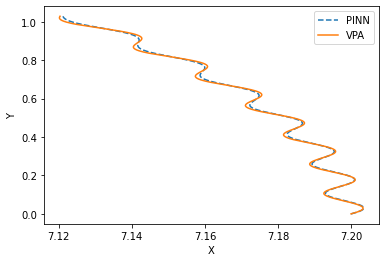

In [135]:
#绘制轨迹，2维
plt.plot(x_coordinates,y_coordinates,linestyle='--', label='PINN')
plt.plot(x_real_plt, y_real_plt,label='VPA')


plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
# plt.title('PINN results VS classic results')
plt.show()

In [136]:
file_lists = [x_coordinates, y_coordinates, z_coordinates]
file_names = ['hh_outputx.txt', 'hh_outputy.txt', 'hh_outputz.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


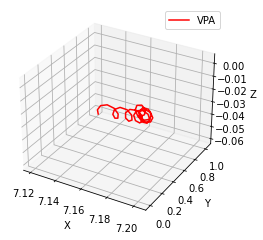

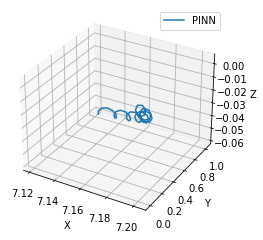

In [138]:
# 绘制轨迹 3维
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_plt[::int(n_all/50)], y_plt[::int(n_all/50)] ,z_plt[::int(n_all/50)],color='red',label='VPA')
#ax.plot(x_coordinates[::int(n_all/100)],y_coordinates[::int(n_all/100)],z_coordinates[::int(n_all/100)],label='neural network')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot(x_plt[::int(n_all/100)], y_plt[::int(n_all/100)] ,z_plt[::int(n_all/100)],label='classic computation')
ax.plot(x_coordinates[::int(n_all/50)],y_coordinates[::int(n_all/50)],z_coordinates[::int(n_all/50)],label='PINN')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field')
plt.show()

In [10]:
with open(new_prefix +'_loss.txt', 'r') as file2:
    loss_list = [float(line.strip()) for line in file2.readlines()]
    loss_list=loss_list[-1000:]
with open(new_prefix +'_lpde.txt', 'r') as file3:
    lpde_list = [float(line.strip()) for line in file3.readlines()]
    lpde_list=lpde_list[-1000:]
with open(new_prefix +'_l0.txt', 'r') as file4:
    l0_list = [float(line.strip()) for line in file4.readlines()]
    l0_list=l0_list[-1000:]
with open(new_prefix +'_lE.txt', 'r') as file5:
    lE_list = [float(line.strip()) for line in file5.readlines()]
    lE_list=lE_list[-1000:]
with open(new_prefix +'_loss_test.txt', 'r') as file6:
    loss_test_list = [float(line.strip()) for line in file6.readlines()]
    loss_test_list=loss_test_list[-1000:]
with open(new_prefix +'_lossmean_test.txt', 'r') as file6:
    lossmean_test_list = [float(line.strip()) for line in file6.readlines()]
    lossmean_test_list=lossmean_test_list[-1000:]

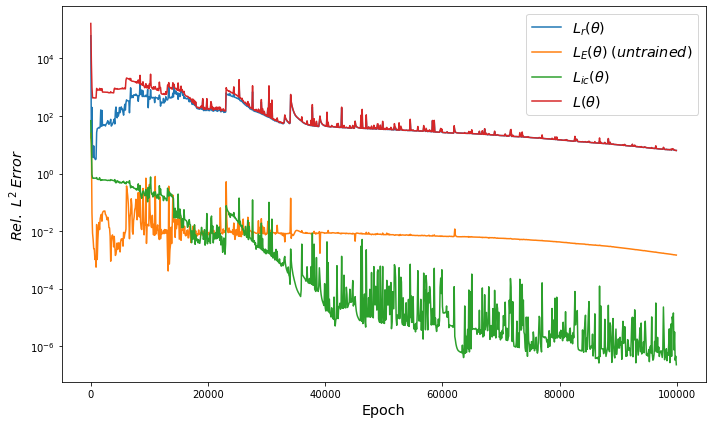

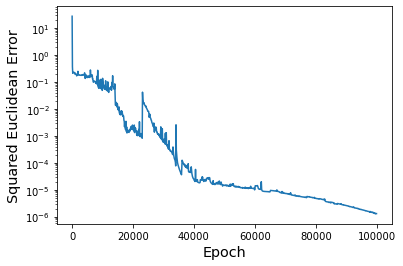

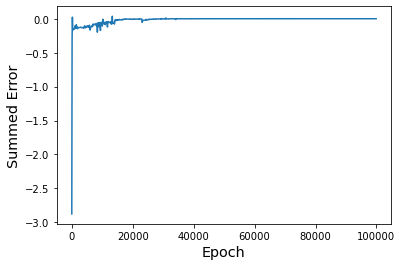

In [12]:

#绘制各loss成分随训练次数epoch变化图
epoch_total = len(loss_list)
epoch_array = np.array(range(0, epoch_total * n_epoch, n_epoch))

plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(epoch_array,lpde_list,label=r'$L_{r}(\theta)$')
#plt.plot(epoch_array,lmiu_list, label='Loss of μ ')
plt.plot(epoch_array,lE_list, label=r'$L_{E}(\theta)\;(untrained)$')
plt.plot(epoch_array,l0_list, label=r'$L_{ic}(\theta)$')
plt.plot(epoch_array,loss_list, label=r'$L(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title(r'$Convergence\;of\;rel.\;L^2\;error\;during\;training\;process$')
# 添加图例并设置字体大小，并将其放在图形外部
plt.legend(fontsize='x-large', loc='upper right')


plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()


# plt.plot(epoch_array,lamda1_list,label=r'$λ_{r}(\theta)$')

# plt.plot(epoch_array,lamda3_list,label=r'$λ_{ic}(\theta)$')
# #plt.plot(epoch_array,lamda4_list,label='λ for loss of μ')
# plt.yscale('log')  # 设置纵轴为对数刻度
# plt.xlabel('Epoch', fontsize='x-large')
# plt.ylabel('Adaptive weights', fontsize='x-large')
# # plt.title('Adaptive weights during training process')
# plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

# plt.show()#绘图

plt.plot(epoch_array,loss_test_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric difference of position from classic data during training process')

plt.show()#绘图

plt.plot(epoch_array,lossmean_test_list)
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')
# plt.title('Arithmetic difference of position from classic data during training process')

plt.show()#绘图

In [124]:
#绘制损失函数在各时刻的分布
lpde_tl_list=[]

lE_tl_list=[]

loss_test_tl_list=[]

lossmean_test_tl_list=[]
for i in range(jump,(n_all+1+jump),10):
    t_tl = torch.tensor([i*interval]).view(-1, 1).requires_grad_(True)#tl:trainloss
    x_tl = u(t_tl)[:,0]
    y_tl = u(t_tl)[:,1]
    z_tl = u(t_tl)[:,2]
    vx_tl = gradients(x_tl, t_tl, 1)
    vy_tl = gradients(y_tl, t_tl, 1)
    vz_tl = gradients(z_tl, t_tl, 1)
    lpde1_tl = loss(gradients(vx_tl, t_tl, 1), q_over_m*(Ex + vy_tl * Bz(x_tl,y_tl,z_tl) - vz_tl * By(x_tl,y_tl,z_tl)))
    lpde2_tl = loss(gradients(vy_tl, t_tl, 1), q_over_m*(Ey + vz_tl * Bx(x_tl,y_tl,z_tl) - vx_tl * Bz(x_tl,y_tl,z_tl)))
    lpde3_tl = loss(gradients(vz_tl, t_tl, 1), q_over_m*(Ez + vx_tl * By(x_tl,y_tl,z_tl) - vy_tl * Bx(x_tl,y_tl,z_tl)))
    lE_tl = loss((vx_tl**2+vy_tl**2+vz_tl**2)**0.5,tensortarget)
    lpde_tl = lpde1_tl + lpde2_tl + lpde3_tl
    x_real_tl = x_real_plt[i-jump]
    y_real_tl = y_real_plt[i-jump]
    z_real_tl = z_real_plt[i-jump]
    vx_real_tl = vx_real_plt[i-jump]
    vy_real_tl = vy_real_plt[i-jump]
    vz_real_tl = vz_real_plt[i-jump]
    loss_test_tl = loss(x_tl,x_real_tl)+loss(y_tl,y_real_tl)+loss(z_tl,z_real_tl)
    lossmean_test_tl = (x_tl-x_real_tl+y_tl-y_real_tl+z_tl-z_real_tl)
    lpde_tl_list.append(lpde_tl.item())
    lE_tl_list.append(lE_tl.item())
    loss_test_tl_list.append(loss_test_tl.item())
    lossmean_test_tl_list.append(lossmean_test_tl.item())
tl_array = np.arange(jump*interval, (n_all+1+jump)*interval, 10*interval)




C:\Users\hxm\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [125]:
# 用作提醒
# lpde_tl_list=[]
# lcq_tl_list=[]
# lE_tl_list=[]
# lmiu_tl_list=[]
# loss_test_tl_list=[]
# lmiu_test_tl_list=[]
# lossmean_test_tl_list=[]

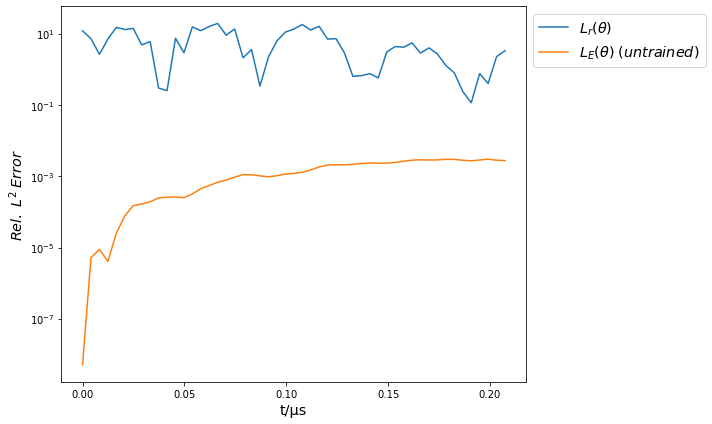

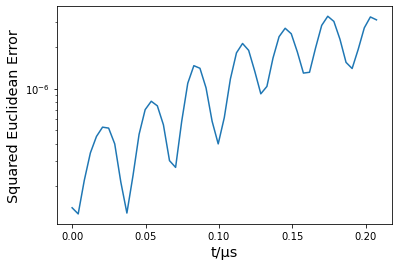

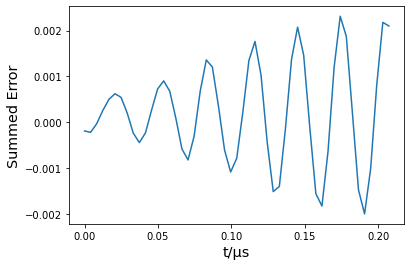

In [126]:
plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(tl_array,lpde_tl_list,label=r'$L_{r}(\theta)$')
plt.plot(tl_array,lE_tl_list,label=r'$L_{E}(\theta)\;(untrained)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title('Loss of ODEs and loss of E from real data during motion process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()
plt.plot(tl_array,loss_test_tl_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric differences of position from real data during motion process')

plt.show()#绘图
plt.plot(tl_array,lossmean_test_tl_list)
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')
# plt.title('Arithmetic differences of position from real data during motion process')

plt.show()#绘图

In [127]:
file_lists = [lpde_tl_list,  lE_tl_list,  loss_test_tl_list, lossmean_test_tl_list]
file_names = ['hh_lpde_tl_list.txt', 'hh_lE_tl_list.txt',  'hh_loss_test_tl_list.txt', 'hh_lossmean_test_tl_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)
